In [ ]:
#IMPORTS
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

## I- INITIALIZATION AND DEFINITIONS

#   Necessary metric for this method

In [ ]:
def calculate_ber(binary_tensor, continuous_tensor):           
    # Ensure tensors are of the same shape
    assert binary_tensor.shape == continuous_tensor.shape, "Tensors must have the same shape"

    # Flatten tensors to 1D arrays
    binary_flat = binary_tensor.flatten()
    continuous_flat = continuous_tensor.flatten()

    # Convert continuous tensor to binary based on threshold 0.5
    binary_pred = (continuous_flat >= 0.5).float()

    # Calculate bit errors
    errors = torch.abs(binary_flat - binary_pred).sum().item()

    # Calculate bit error rate
    ber = errors / binary_flat.numel()

    return ber

In [ ]:
imt_logo=np.zeros((8,16))                       #TOMOD
imt_logo[0,:]=[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
imt_logo[1,:]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
imt_logo[2,:]=[1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,0]
imt_logo[3,:]=[0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1]
imt_logo[4,:]=[1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0]
imt_logo[5,:]=[0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,1]
imt_logo[6,:]=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
imt_logo[7,:]=[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]


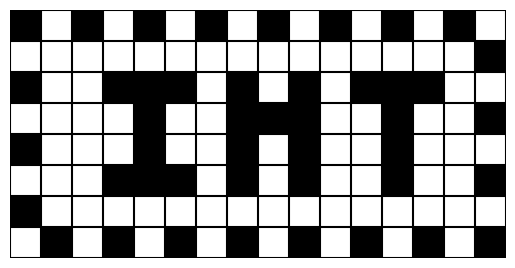

In [ ]:
#affichage
plt.imshow(imt_logo, cmap='binary')
plt.axis('off')
rows, cols = imt_logo.shape
for i in range(rows + 1):
    plt.axhline(y=i - 0.5, color='black', linewidth=1.5)  # Horizontal lines

for j in range(cols + 1):
    plt.axvline(x=j - 0.5, color='black', linewidth=1.5)  # Turn off axis
plt.show()

In [ ]:
imt_logo=np.reshape(imt_logo,(128,))
imt_logo_tensor=torch.tensor(imt_logo)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

# Set batch size
batch_size = 2   #small batch_size 

# Load MNIST train dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load MNIST test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes for MNIST (digits 0-9)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [ ]:
#HEREIN IS THE UCHIDA METHOD
class WatermarkLoss(nn.Module):
    def __init__(self,key,mark):
        super(WatermarkLoss, self).__init__()
        self.key=key
        self.mark=mark.float()

    def forward(self,weights):
        y = torch.mean(weights, dim=3)
        z = y.view(1, -1)
        d=torch.sigmoid(torch.matmul(z, self.key))
        d=d.squeeze()
        d=d.float()
        loss=F.binary_cross_entropy(d, self.mark)
        return loss


In [ ]:
#simple CNN Mnist
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Adjust input channels to 1 for grayscale images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjust input size after max pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## II - TRAINING MODEL

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
random_testaccuracy = []
epochs = 30             #TOMOD 5 epochs is more than enough
random_losses= []
random_watermark_losses=[]
unmodified_key= net.conv2.weight
print("layer shape is : ",unmodified_key.shape)


layer shape torch.Size([16, 6, 5, 5])


In [ ]:
# Define watermark input and output
key = torch.randn(480,128)        #Random method for keyt generation (diff and direct methodss are not implemented T-T  )
mark = imt_logo_tensor
mark=mark.double()
waterloss=WatermarkLoss(key,mark)
alpha=0.05 #importance of watermark loss coefficient

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    watermark_loss = waterloss(net.conv2.weight)
    total_loss = loss +  alpha * watermark_loss          #TOMOD
    total_loss.backward()
    optimizer.step()
          # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
      (epoch + 1, i + 1, running_loss / 2000))
      random_losses.append(loss)
      random_watermark_losses.append(watermark_loss)
      running_loss = 0.0

  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d%%' % (100 * correct / total))
  random_testaccuracy.append(correct/total)

print('Finished Training')

[1,  2000] loss: 1.332
[1,  4000] loss: 0.254
[1,  6000] loss: 0.220
[1,  8000] loss: 0.167
[1, 10000] loss: 0.123
[1, 12000] loss: 0.122
[1, 14000] loss: 0.126
[1, 16000] loss: 0.104
[1, 18000] loss: 0.095
[1, 20000] loss: 0.080
[1, 22000] loss: 0.099
[1, 24000] loss: 0.086
[1, 26000] loss: 0.082
[1, 28000] loss: 0.079
[1, 30000] loss: 0.072
Accuracy of the network on the 10000 test images: 98%
[2,  2000] loss: 0.065
[2,  4000] loss: 0.059
[2,  6000] loss: 0.061
[2,  8000] loss: 0.061
[2, 10000] loss: 0.070
[2, 12000] loss: 0.054
[2, 14000] loss: 0.075
[2, 16000] loss: 0.062
[2, 18000] loss: 0.052
[2, 20000] loss: 0.055
[2, 22000] loss: 0.064
[2, 24000] loss: 0.058
[2, 26000] loss: 0.057
[2, 28000] loss: 0.053
[2, 30000] loss: 0.063
Accuracy of the network on the 10000 test images: 98%
[3,  2000] loss: 0.035
[3,  4000] loss: 0.039
[3,  6000] loss: 0.045
[3,  8000] loss: 0.037
[3, 10000] loss: 0.043
[3, 12000] loss: 0.052
[3, 14000] loss: 0.038
[3, 16000] loss: 0.041
[3, 18000] loss: 0

In [ ]:
torch.save(net.state_dict(), 'net_weights.pth')                   #TOMOD
torch.save(net.state_dict(), '/content/model_weights.pth')        #TOMOD

Visualize the computational graph of the model in order to verify its' functioning

In [ ]:
from torchviz import make_dot


# Assuming trainloader is your DataLoader containing your dataset

# Get the first data sample from the dataset
first_data_sample = next(iter(trainloader.dataset))

# Extract the input from the data sample
inputs, _ = first_data_sample

# Inspect the shape of the input data
input_size = inputs.shape  # Assuming inputs is a tensor
print("Input size:", input_size)

# Dummy input data
dummy_input = torch.randn(1, *input_size)

# Create computational graph
dot = make_dot(net(dummy_input), params=dict(net.named_parameters()))

# Save the graph as a PNG file
dot.render("computational_graph", format="png")
#from google.colab import files                 #TOMOD

# Download the file
#files.download('computational_graph.png')          #TOMOD

In [ ]:
loss_list = [tensor.item() for tensor in random_losses]
plt.plot(loss_list)

In [ ]:
watermark_loss_list = [tensor.item() for tensor in random_watermark_losses]

plt.plot(watermark_loss_list)
plt.show()

## III - PRUNING ATTACK

In [ ]:
pruned_model=Net()
pruned_model.load_state_dict(torch.load('net_weights.pth'))

<All keys matched successfully>

In [ ]:
import torch.nn.utils.prune as prune
module = pruned_model.conv2
prune.l1_unstructured(module, name="weight", amount=0.5)  # Prune amount% of the weights #TOMOD

# Remove zeroed weights
prune.remove(module, "weight")

Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))

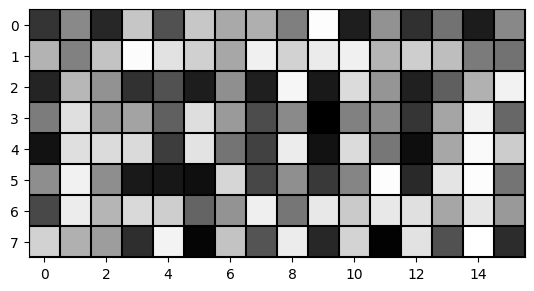

In [ ]:
y = torch.mean(pruned_model.conv2.weight, dim=3)
z = y.view(1, -1)
d=torch.sigmoid(torch.matmul(z,key))
d=d.squeeze()
pruned_d=d.float()
np_predicted=np.array([tensor.item() for tensor in pruned_d])
np_predicted=np.reshape(np_predicted,(8,16))
plt.imshow(np_predicted, cmap='binary')
rows, cols = np_predicted.shape
for i in range(rows + 1):
    plt.axhline(y=i - 0.5, color='black', linewidth=1.5)  # Horizontal lines

for j in range(cols + 1):
    plt.axvline(x=j - 0.5, color='black', linewidth=1.5)
plt.show()

In [ ]:

ber = calculate_ber(mark, pruned_d)
print("Bit Error Rate:", ber)


Bit Error Rate: 0.09375


## RESULTS VISUALISATION

In [ ]:
y = torch.mean(net.conv2.weight, dim=3)
z = y.view(1, -1)
d=torch.sigmoid(torch.matmul(z,key))
d=d.squeeze()
d=d.float()
#D is the predicted KEY VALUE


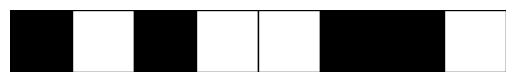

In [ ]:
def draw_boxes(binary_list, box_size=1.0, edge_color='black', edge_width=1.0):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i, value in enumerate(binary_list):
        face_color = 'white' if value >= 0.5 else 'black'
        rect = plt.Rectangle((i * box_size, 0), box_size, box_size, facecolor=face_color, edgecolor=edge_color, linewidth=edge_width)
        ax.add_patch(rect)

    plt.xlim(0, len(binary_list) * box_size)
    plt.ylim(0, box_size)
    plt.show()

# Example usage
binary_list = [0, 1, 0, 1, 1, 0, 0, 1]
draw_boxes(binary_list, box_size=2.0, edge_color='black', edge_width=1.0)

In [ ]:
def draw_difference(binary_list,binary_list_2,box_size=1.0, edge_color='black', edge_width=1.0):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()
    binary_np=np.array([tensor.item() for tensor in binary_list])
    binary_np_2=np.array([tensor.item() for tensor in binary_list_2])
    difference=np.abs(binary_np-binary_np_2)
    for i, value in enumerate(difference):
        face_color = 'red' if value >= 0.5 else 'green'
        rect = plt.Rectangle((i * box_size, 0), box_size, box_size, facecolor=face_color, edgecolor=edge_color, linewidth=edge_width)
        ax.add_patch(rect)

    plt.xlim(0, len(binary_list) * box_size)
    plt.ylim(0, box_size)
    plt.show()
# IF TWO CELLS ARE THE SAME THE OUTPUT IS GREEN OTHERWISSE IT IS RED

the original message is: 


the recovered message is: 


the difference is :


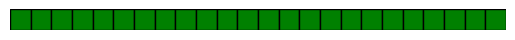

In [ ]:
print('the original message is: ')
draw_boxes(mark, box_size=2.0, edge_color='black', edge_width=1.0)
print('the recovered message is: ')
draw_boxes(d, box_size=2.0, edge_color='black', edge_width=1.0)
print('the difference in the first 24 boxes is :')
draw_difference(d[0:24],mark[0:24],box_size=2.0, edge_color='black', edge_width=1.0)

In [ ]:
# bIT ERROR RATE CALCULATION
ber = calculate_ber(mark, d)
print("Bit Error Rate:", ber)


Bit Error Rate: 0.0


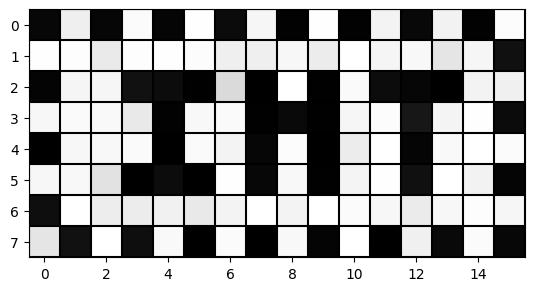

In [ ]:
np_predicted=np.array([tensor.item() for tensor in d])
np_predicted=np.reshape(np_predicted,(8,16))
plt.imshow(np_predicted, cmap='binary')
rows, cols = np_predicted.shape
for i in range(rows + 1):
    plt.axhline(y=i - 0.5, color='black', linewidth=1.5)  # Horizontal lines

for j in range(cols + 1):
    plt.axvline(x=j - 0.5, color='black', linewidth=1.5)
plt.show()

In [ ]:
y = torch.mean(unmodified_key, dim=3)
z = y.view(1, -1)
unmodified_d=torch.sigmoid(torch.matmul(z,key))
unmodified_d=unmodified_d.squeeze()
unmodified_d=unmodified_d.float()


In [ ]:

ber = calculate_ber(mark, unmodified_d)
print("Bit Error Rate:", ber)


Bit Error Rate: 0.0


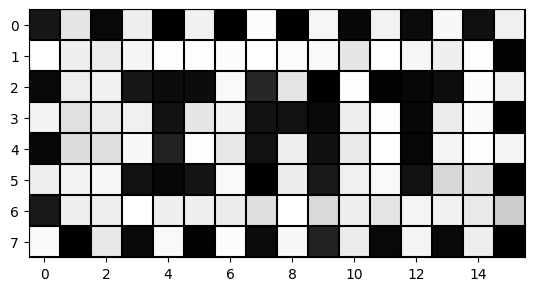

In [ ]:
unmodified_d=np.array([tensor.item() for tensor in unmodified_d])
unmodified_d=np.reshape(unmodified_d,(8,16))
rows, cols = unmodified_d.shape
plt.imshow(unmodified_d,cmap='binary')
for i in range(rows + 1):
    plt.axhline(y=i - 0.5, color='black', linewidth=1.5)  # Horizontal lines

for j in range(cols + 1):
    plt.axvline(x=j - 0.5, color='black', linewidth=1.5)
plt.show()